In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL


module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


from utils.calculate_indices import CalculateIndices

# Load
df_trees_raw = pd.read_csv("../../data/Trainings_Datensatz.csv")

# Processing
df_trees = CalculateIndices.add_all_indices(df_trees_raw)
df_trees["month"] = pd.to_datetime(df_trees["time"]).dt.month
pd.set_option('display.max_columns', 500)

In [2]:
spectral_bands =[col for col in df_trees_raw.columns if col.startswith("b")]
print(spectral_bands)

['b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b8a', 'b11', 'b12']


In [3]:
print(df_trees.columns)

Index(['time', 'id', 'disturbance_year', 'doy', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'b8', 'b8a', 'b11', 'b12', 'species', 'ndvi', 'gndvi', 'wdvi',
       'tndvi', 'savi', 'ipvi', 'mcari', 'reip', 'masvi2', 'dvi', 'month'],
      dtype='object')


In [4]:
# Nur soil und diturbed haben ein disturbance year

df_trees[(df_trees["species"] != "disturbed") & (df_trees["disturbance_year"] != 0)]["species"].unique()

array(['soil'], dtype=object)

## Stationarität

In [19]:
df_trees_stationary = df_trees_raw.drop(columns=["doy", "disturbance_year", "id"])
df_trees_stationary["time"] = pd.to_datetime(df_trees["time"])
df_trees_stationary = df_trees_stationary[(df_trees_stationary["species"] == "oak") & (df_trees_stationary["time"].dt.year == 2020)]

In [20]:
df_trees_stationary = df_trees_stationary.groupby(["time", "species"]).mean().reset_index()[["b12", "time"]]

In [23]:
px.line(df_trees_stationary, x="time", y="b12", title="Oak - 2020")

ADF-Test:
  Teststatistik: -2.1083
  p-Wert:       0.2412
  Kritische Werte: {'1%': np.float64(-3.44880082033912), '5%': np.float64(-2.869670179576637), '10%': np.float64(-2.5711012838861036)}
  ⇒ Nullhypothese nicht verwerfen: Nicht stationär

KPSS-Test:
  Teststatistik: 1.2607
  p-Wert:       0.0100
  Kritische Werte: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  ⇒ Nullhypothese verwerfen: Nicht stationär



/tmp/ipykernel_5030/2320864107.py:18: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




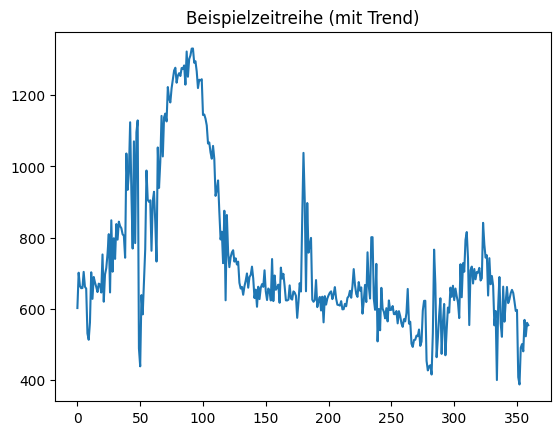

In [27]:
# Beispiel mit species oak


# --- ADF Test ---
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF-Test:')
    print(f'  Teststatistik: {result[0]:.4f}')
    print(f'  p-Wert:       {result[1]:.4f}')
    print(f'  Kritische Werte: {result[4]}')
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Nicht stationär\n")

# --- KPSS Test ---
def kpss_test(series):
    result = kpss(series, regression='c', nlags="auto")
    print('KPSS-Test:')
    print(f'  Teststatistik: {result[0]:.4f}')
    print(f'  p-Wert:       {result[1]:.4f}')
    print(f'  Kritische Werte: {result[3]}')
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Nicht stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Stationär\n")

# Tests ausführen
adf_test(df_trees_stationary["b12"])
kpss_test(df_trees_stationary["b12"])

# Plot zur Visualisierung
df_trees_stationary["b12"].plot(title="Beispielzeitreihe (mit Trend)")
plt.show()

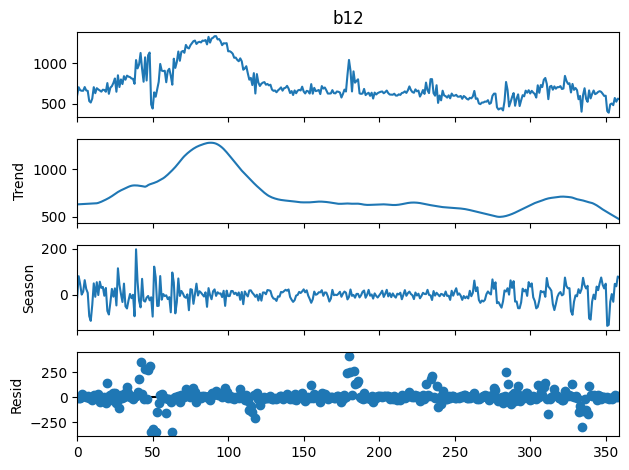

In [30]:
stl = STL(df_trees_stationary["b12"], period=12, robust=True)
res = stl.fit()

# Komponenten
trend = res.trend
season = res.seasonal
residual = res.resid

# Visualisierung
res.plot()
plt.show()

# Trend- und Saisonbereinigung
df_trees_stationary["b12_adjusted"] = residual


In [31]:
px.line(df_trees_stationary, x="time", y="b12_adjusted", title="Oak - 2020")

ADF-Test:
  Teststatistik: -8.0183
  p-Wert:       0.0000
  Kritische Werte: {'1%': np.float64(-3.448853029339765), '5%': np.float64(-2.869693115704379), '10%': np.float64(-2.571113512498422)}
  ⇒ Nullhypothese verwerfen: Stationär

KPSS-Test:
  Teststatistik: 0.0930
  p-Wert:       0.1000
  Kritische Werte: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  ⇒ Nullhypothese nicht verwerfen: Stationär



/tmp/ipykernel_5030/1541762558.py:18: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




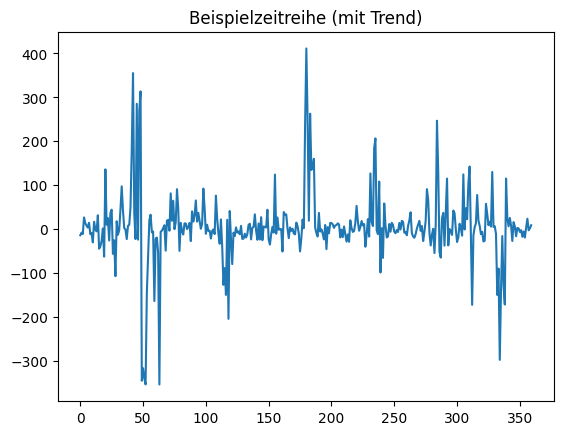

In [32]:
# Beispiel mit species oak


# --- ADF Test ---
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF-Test:')
    print(f'  Teststatistik: {result[0]:.4f}')
    print(f'  p-Wert:       {result[1]:.4f}')
    print(f'  Kritische Werte: {result[4]}')
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Nicht stationär\n")

# --- KPSS Test ---
def kpss_test(series):
    result = kpss(series, regression='c', nlags="auto")
    print('KPSS-Test:')
    print(f'  Teststatistik: {result[0]:.4f}')
    print(f'  p-Wert:       {result[1]:.4f}')
    print(f'  Kritische Werte: {result[3]}')
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Nicht stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Stationär\n")

# Tests ausführen
adf_test(df_trees_stationary["b12_adjusted"])
kpss_test(df_trees_stationary["b12_adjusted"])

# Plot zur Visualisierung
df_trees_stationary["b12_adjusted"].plot(title="Beispielzeitreihe (mit Trend)")
plt.show()

## Korrelation

In [21]:
df_trees_encoded = pd.get_dummies(df_trees, columns=["species", "month"])
corr_matrix = df_trees_encoded.drop(columns=["id", "time", "doy", "disturbance_year"]).corr()

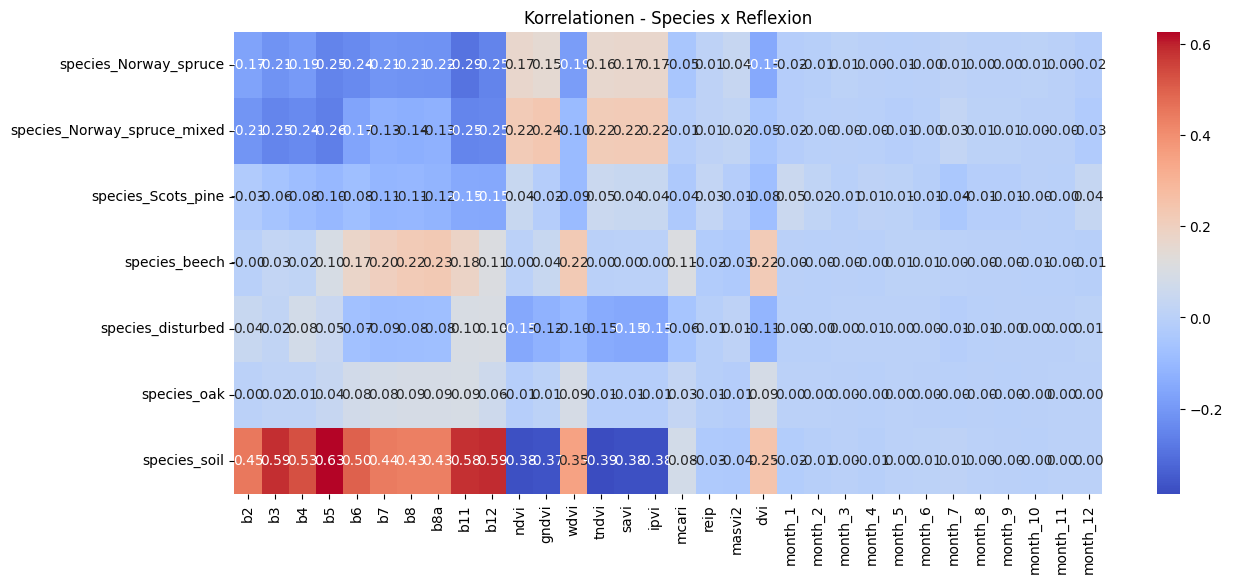

In [22]:
zielvariablen = ['species_Norway_spruce',
       'species_Norway_spruce_mixed', 'species_Scots_pine', 'species_beech',
       'species_disturbed', 'species_oak', 'species_soil']

plt.figure(figsize=(14, 6))
sns.heatmap(
    corr_matrix[zielvariablen].T.drop(columns=zielvariablen), 
    annot=True, fmt=".2f", cmap="coolwarm", cbar=True
)
plt.title("Korrelationen - Species x Reflexion")
plt.show()


## Feature importance

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


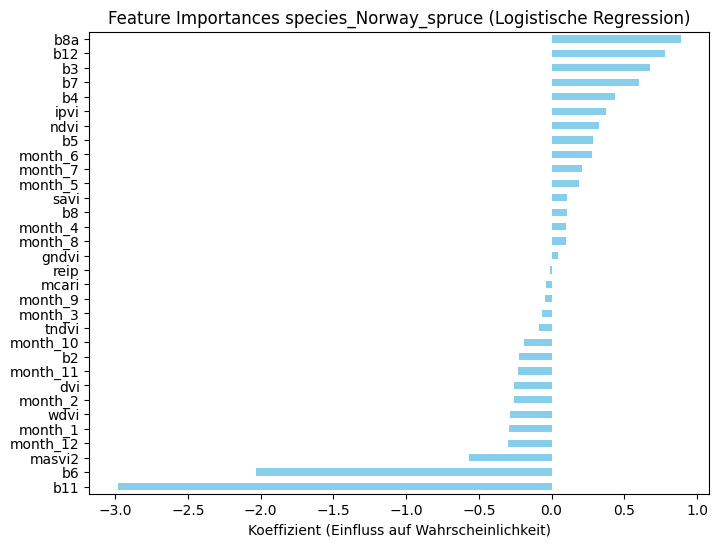

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


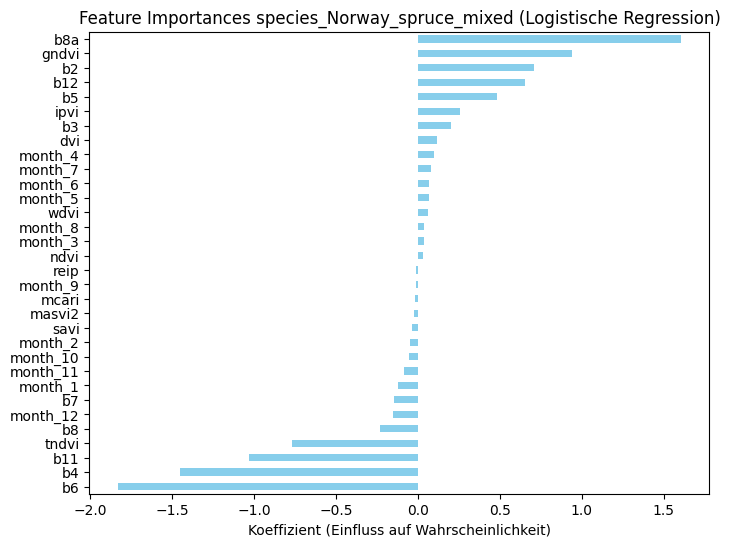

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


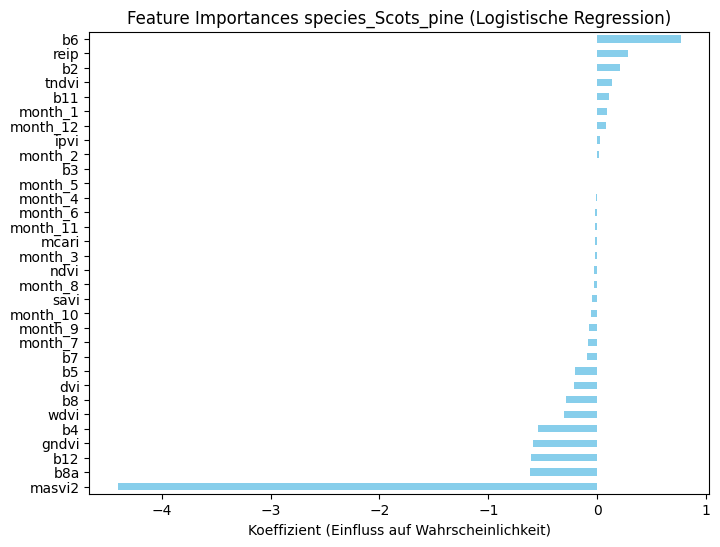

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


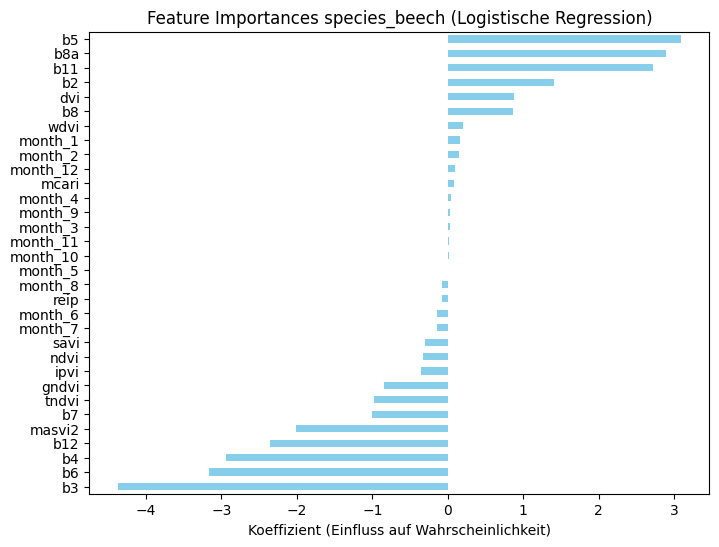

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


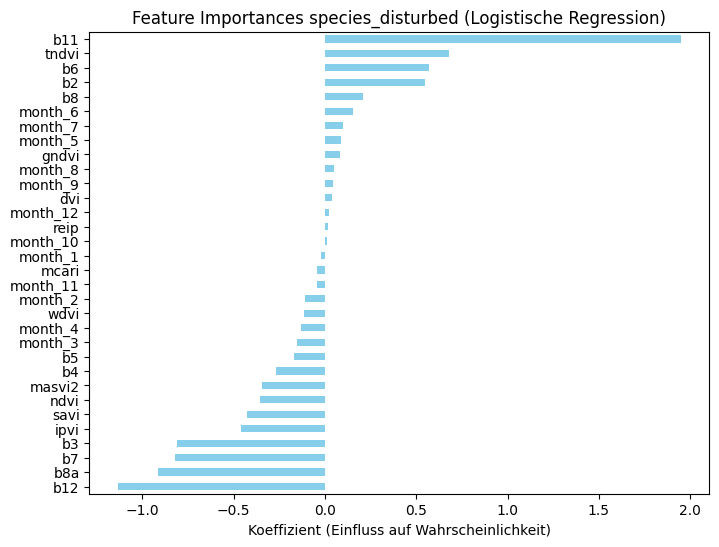

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


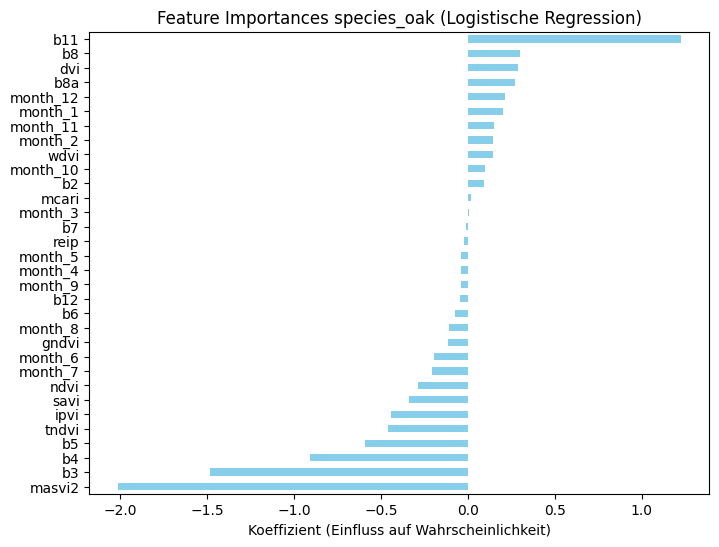

/home/alexandru/Dokumente/Studium/Semester 7/Domänenprojekt 2/tree_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


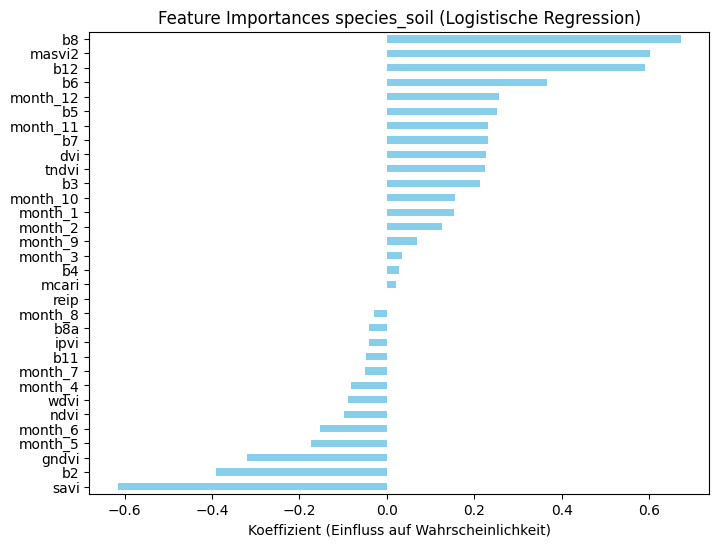

In [ ]:
all_coefs = []

for variable in zielvariablen:

    df_sorted = df_trees_encoded.sort_values("time").drop(columns=["id", "time", "doy", "disturbance_year"])

    split_idx = int(len(df_sorted) * 0.8)
    train = df_sorted.iloc[:split_idx]
    test  = df_sorted.iloc[split_idx:]

    X_train = train.drop(columns=[variable])
    y_train = train[variable]
    X_test  = test.drop(columns=[variable])
    y_test  = test[variable]



    X = df_sorted.drop(columns=zielvariablen)   # Features
    y = df_sorted[variable]                  # Zielvariable (0/1)   

    # Inf/NaN behandeln
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)

    tscv = TimeSeriesSplit(n_splits=5)

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Klassifikationsmodell (statt LinearRegression)
    model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=10, solver="liblinear", penalty="l1"))
    model.fit(X_train, y_train)

    # Feature Importances = Koeffizienten der logistischen Regression
    logreg = model.named_steps["logisticregression"]
    coefficients = pd.Series(logreg.coef_[0], index=X.columns).sort_values()
    all_coefs.append(coefficients)

    # Plot
    plt.figure(figsize=(8, 6))
    coefficients.plot(kind="barh", color="skyblue")
    plt.title(f"Feature Importances {variable} (Logistische Regression)")
    plt.xlabel("Koeffizient (Einfluss auf Wahrscheinlichkeit)")
    plt.show()

In [16]:
coef_df = pd.concat(all_coefs, axis=1)

In [17]:
all_coefs

[b11        -2.982459
 b6         -2.033026
 masvi2     -0.565194
 month_12   -0.296354
 month_1    -0.293201
 wdvi       -0.284906
 month_2    -0.260863
 dvi        -0.258977
 month_11   -0.233188
 b2         -0.224357
 month_10   -0.186401
 tndvi      -0.088772
 month_3    -0.064022
 month_9    -0.046024
 mcari      -0.034832
 reip       -0.007130
 gndvi       0.045163
 month_8     0.098276
 month_4     0.102289
 b8          0.103390
 savi        0.106553
 month_5     0.187396
 month_7     0.211596
 month_6     0.274791
 b5          0.287267
 ndvi        0.323732
 ipvi        0.373900
 b4          0.433856
 b7          0.600451
 b3          0.677930
 b12         0.782943
 b8a         0.891940
 dtype: float64,
 b6         -1.833755
 b4         -1.451423
 b11        -1.030239
 tndvi      -0.768633
 b8         -0.233748
 month_12   -0.154936
 b7         -0.148485
 month_1    -0.124118
 month_11   -0.084056
 month_10   -0.057402
 month_2    -0.046984
 savi       -0.038568
 masvi2     -0.

In [18]:
coef_df

,0,1,2,3,4,5,6
b11,-2.982459,-1.030239,0.104443,2.712468,1.951483,1.226332,-0.047616
b6,-2.033026,-1.833755,0.772505,-3.159664,0.571021,-0.071667,0.365995
masvi2,-0.565194,-0.024169,-4.404008,-2.013062,-0.345657,-2.013504,0.601291
month_12,-0.296354,-0.154936,0.078584,0.098441,0.024860,0.215572,0.257380
month_1,-0.293201,-0.124118,0.092542,0.156349,-0.022120,0.198884,0.153927
wdvi,-0.284906,0.060247,-0.306358,0.202255,-0.115000,0.143611,-0.088755
month_2,-0.260863,-0.046984,0.015675,0.141005,-0.106863,0.145831,0.125835
dvi,-0.258977,0.117020,-0.210440,0.879716,0.037504,0.286763,0.225794
month_11,-0.233188,-0.084056,-0.018069,0.017491,-0.042968,0.151627,0.231339
b2,-0.224357,0.710420,0.211137,1.402789,0.545288,0.090567,-0.390641


In [19]:
coef_df.median(axis=1).sort_values(ascending=False)

b8a         0.270133
b5          0.251301
b2          0.211137
b8          0.206273
dvi         0.117020
b11         0.104443
month_1     0.092542
month_12    0.078584
month_2     0.015675
month_10    0.008796
month_3     0.005747
month_5     0.003085
b3         -0.000409
reip       -0.007130
month_9    -0.011322
month_4    -0.015236
month_6    -0.016601
month_11   -0.018069
mcari      -0.018382
month_8    -0.029538
ipvi       -0.041826
b12        -0.046269
month_7    -0.049953
b6         -0.071667
wdvi       -0.088755
tndvi      -0.088772
b7         -0.093023
ndvi       -0.098188
gndvi      -0.117486
savi       -0.308946
b4         -0.542024
masvi2     -0.565194
dtype: float64